In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet('../data/graphs/metrics/all_metrics.parquet')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19847339 entries, 0 to 19847338
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   date               object 
 1   token              object 
 2   address            object 
 3   in_degree          int64  
 4   out_degree         int64  
 5   pagerank           float64
 6   degree_centrality  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.0+ GB


,date,token,address,in_degree,out_degree,pagerank,degree_centrality
0,2022-04-01,DAI,0x48c04ed5691981c42154c6167398f95e8f38a7ff,11,10,0.002019,0.007332
1,2022-04-01,DAI,0x9c83551e8c31b55e81db9e1aaffeea71c5c0c4e9,1,0,0.000123,0.000349
2,2022-04-01,DAI,0x9008d19f58aabd9ed0d60971565aa8510560ab41,28,28,0.005276,0.019553
3,2022-04-01,DAI,0x882657826c60043cac02d7359743db64932f5c98,2,1,0.000124,0.001047
4,2022-04-01,DAI,0xba12222222228d8ba445958a75a0704d566bf2c8,24,34,0.007257,0.020251


Daily average metrics (PageRank, degrees, centrality) by stablecoin, highlighting the UST collapse in May 2022.


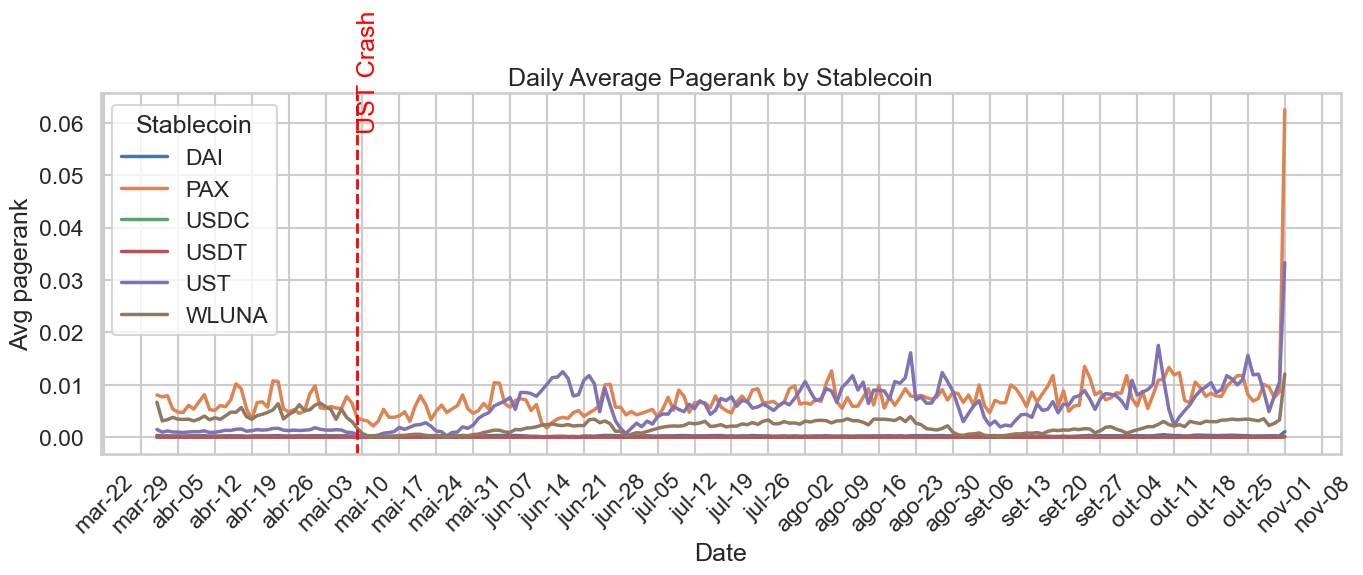

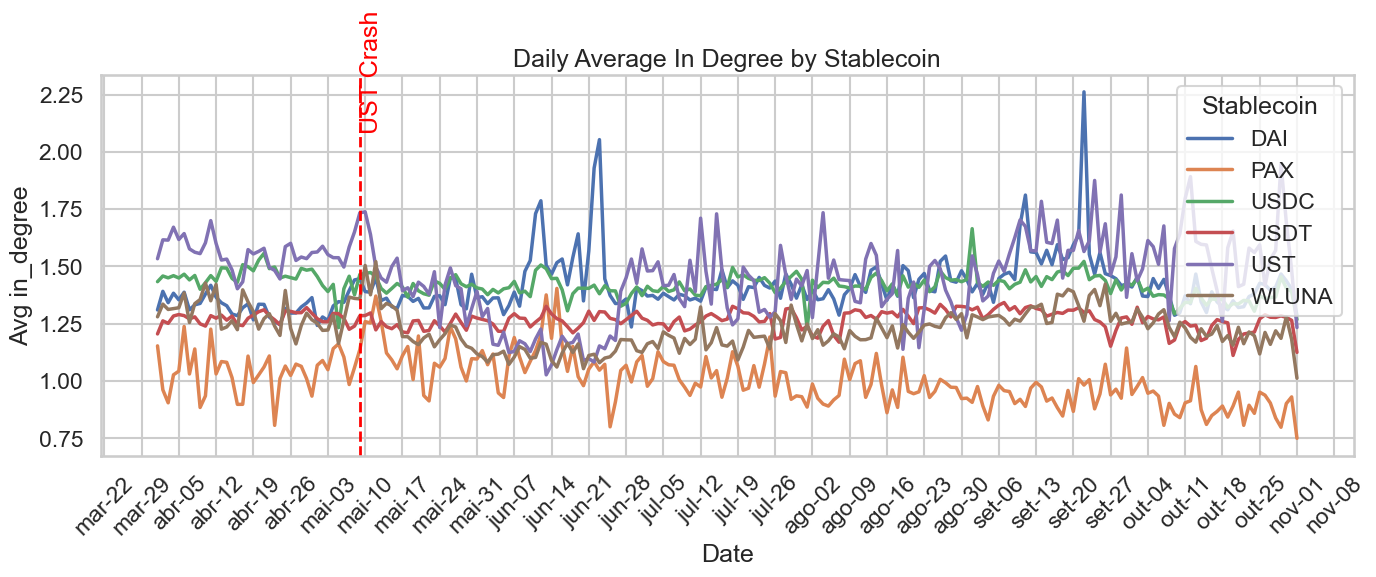

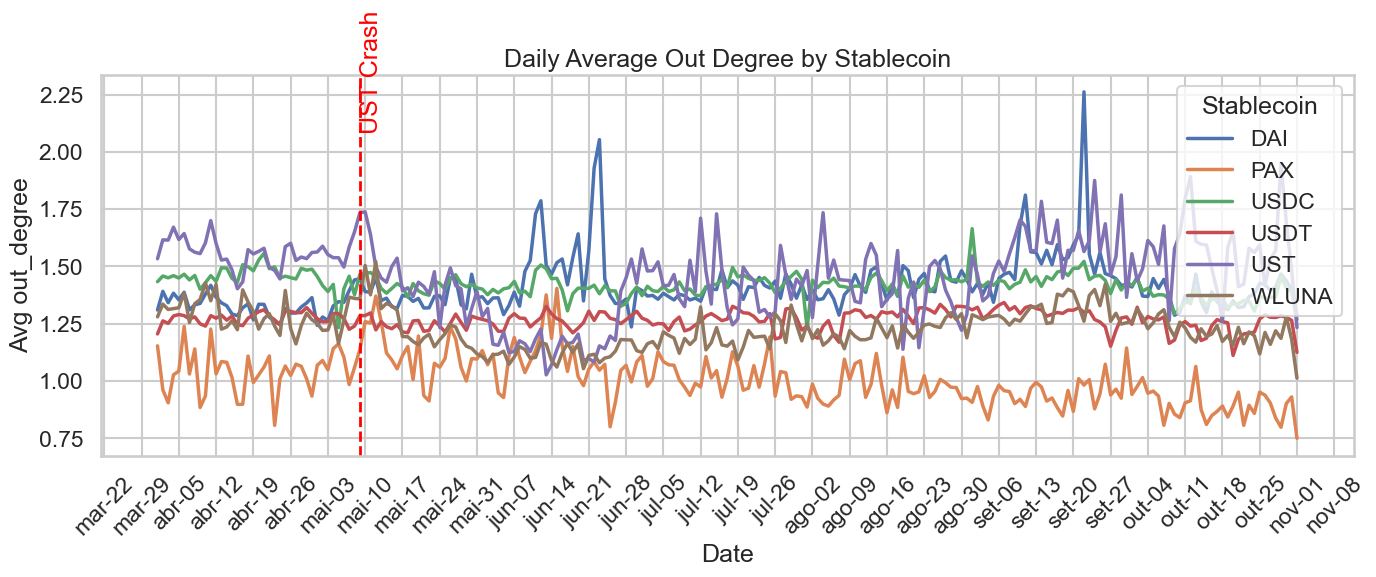

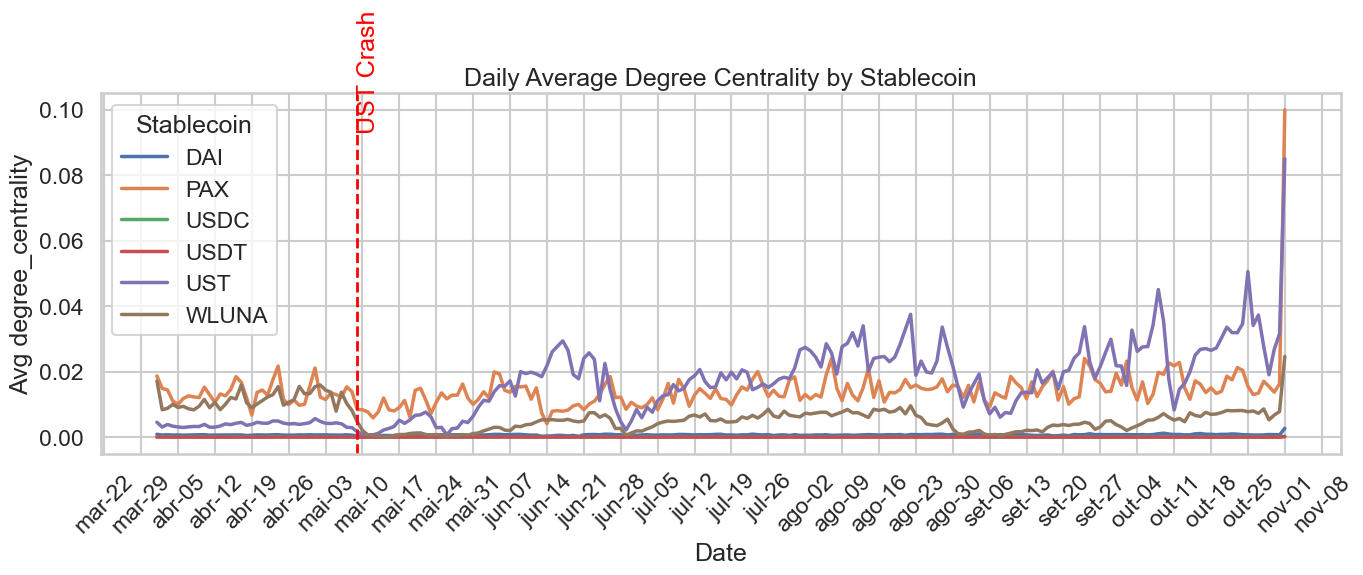

In [6]:

import matplotlib.dates as mdates

sns.set_theme(style="whitegrid", context="talk")
# Garantir que 'date' é datetime
df['date'] = pd.to_datetime(df['date'])

# Data do colapso da UST
ust_crash_date = pd.to_datetime('2022-05-09')

# Métricas a serem analisadas
metrics = ['pagerank', 'in_degree', 'out_degree', 'degree_centrality']

for metric in metrics:
    plt.figure(figsize=(14, 6))
    grouped = df.groupby(['date', 'token'])[metric].mean().reset_index()

    # Gráfico de linhas por token
    sns.lineplot(
        data=grouped,
        x='date', y=metric, hue='token',
        linewidth=2.5
    )

    # Linha vertical no evento
    plt.axvline(ust_crash_date, color='red', linestyle='--', linewidth=2)
    plt.text(ust_crash_date, plt.ylim()[1]*0.9, 'UST Crash', color='red', rotation=90)

    # Formatação do eixo X
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.xticks(rotation=45)

    plt.title(f'Daily Average {metric.replace("_", " ").title()} by Stablecoin')
    plt.xlabel("Date")
    plt.ylabel(f"Avg {metric}")
    plt.legend(title="Stablecoin")
    plt.tight_layout()
    plt.show()

In [11]:
# Statistics

import pandas as pd
from datetime import datetime

# Carrega o arquivo parquet com as métricas por carteira
df = pd.read_parquet('../data/graphs/metrics/all_metrics.parquet')

# Converte coluna 'date' para datetime, se ainda não for
df['date'] = pd.to_datetime(df['date'])

# Define data de corte: colapso da UST
cutoff = datetime(2022, 5, 7)

# Métricas de interesse
metrics = ['pagerank', 'in_degree', 'out_degree', 'degree_centrality']

# Lista para armazenar resultados
results = []

# Agrupa por token
for token in df['token'].unique():
    df_token = df[df['token'] == token]
    
    # Antes e depois do colapso
    df_before = df_token[df_token['date'] < cutoff]
    df_after  = df_token[df_token['date'] >= cutoff]
    
    for metric in metrics:
        mean_before = df_before[metric].mean()
        std_before  = df_before[metric].std()
        mean_after  = df_after[metric].mean()
        std_after   = df_after[metric].std()
        
        percent_change = 100 * (mean_after - mean_before) / mean_before if mean_before != 0 else None

        results.append({
            'token': token,
            'metric': metric,
            'mean_before': mean_before,
            'std_before': std_before,
            'mean_after': mean_after,
            'std_after': std_after,
            'percent_change': percent_change
        })

# Resultado final em DataFrame
df_summary = pd.DataFrame(results)
df_summary.sort_values(by='percent_change', ascending=False, inplace=True)
df_summary.reset_index(drop=True, inplace=True)

# Exibe
print(df_summary.head(10)) 


  token             metric  mean_before  std_before  mean_after  std_after  \
0   UST           pagerank     0.001253    0.005075    0.002898   0.009000   
1   UST  degree_centrality     0.003904    0.017278    0.008394   0.025705   
2   DAI          in_degree     1.326370    5.856087    1.440312  10.315682   
3   DAI         out_degree     1.326370    5.846808    1.440312   5.983478   
4   PAX           pagerank     0.006072    0.008308    0.006235   0.010795   
5   DAI  degree_centrality     0.000699    0.002979    0.000699   0.003098   
6   PAX  degree_centrality     0.012715    0.013973    0.012562   0.015481   
7  USDT         out_degree     1.278413   22.288638    1.262232  21.764617   
8  USDT          in_degree     1.278413   21.202619    1.262232  38.093527   
9   PAX          in_degree     1.051611    2.054923    1.034452   2.451572   

   percent_change  
0      131.212801  
1      115.038518  
2        8.590473  
3        8.590473  
4        2.693787  
5        0.097584  
6

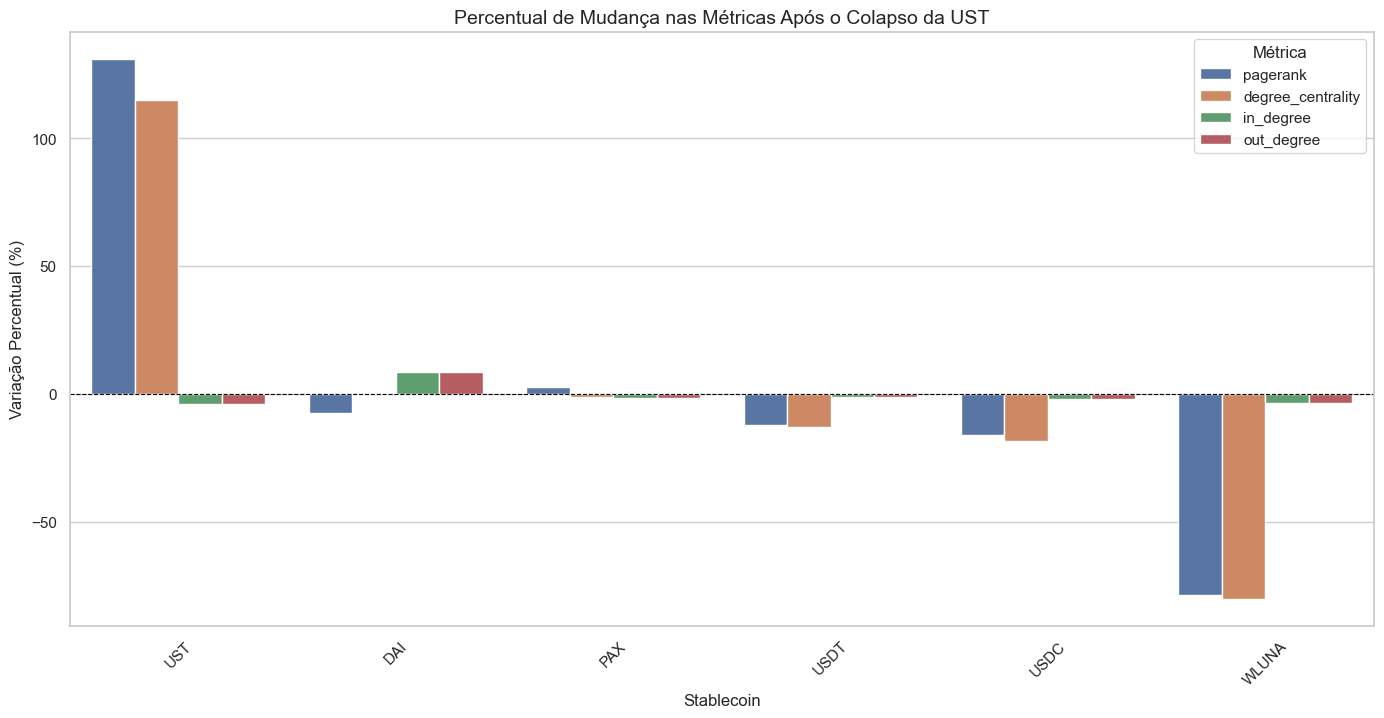

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustar estilo do gráfico
sns.set(style='whitegrid', font_scale=1.0)

# Criar gráfico de barras para variação percentual por token e métrica
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df_summary, x='token', y='percent_change', hue='metric')
ax.set_title('Percentual de Mudança nas Métricas Após o Colapso da UST', fontsize=14)
ax.set_ylabel('Variação Percentual (%)')
ax.set_xlabel('Stablecoin')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(title='Métrica')
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()


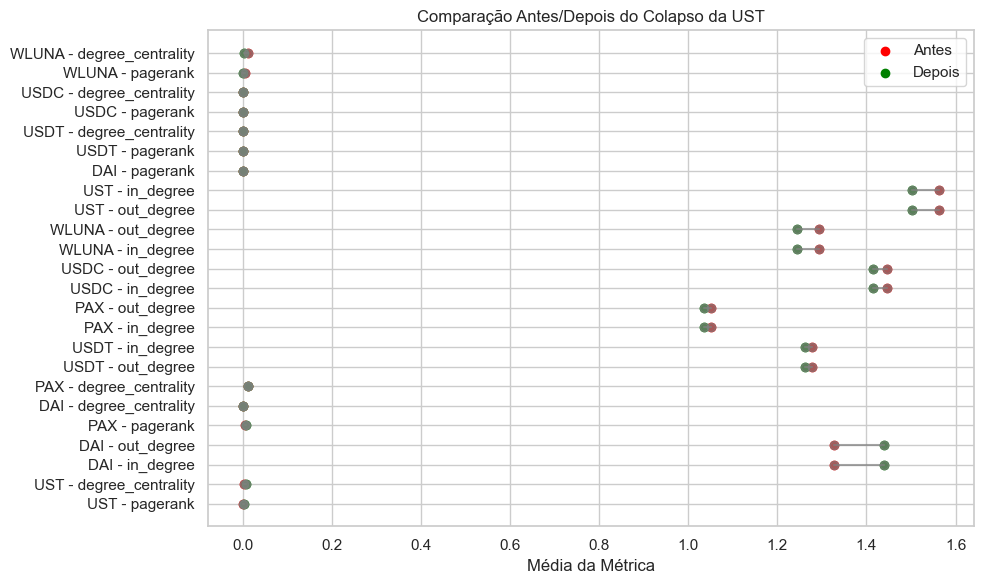

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


df_sorted = df_summary.sort_values('percent_change', ascending=False)

plt.figure(figsize=(10, 6))
for i, row in enumerate(df_sorted.itertuples()):
    plt.plot([row.mean_before, row.mean_after], [i, i], 'o-', color='grey', alpha=0.7)
    plt.scatter(row.mean_before, i, color='red', label='Antes' if i == 0 else "")
    plt.scatter(row.mean_after, i, color='green', label='Depois' if i == 0 else "")

plt.yticks(range(len(df_sorted)), [f"{r.token} - {r.metric}" for r in df_sorted.itertuples()])
plt.xlabel('Média da Métrica')
plt.title('Comparação Antes/Depois do Colapso da UST')
plt.legend()
plt.tight_layout()
plt.show()

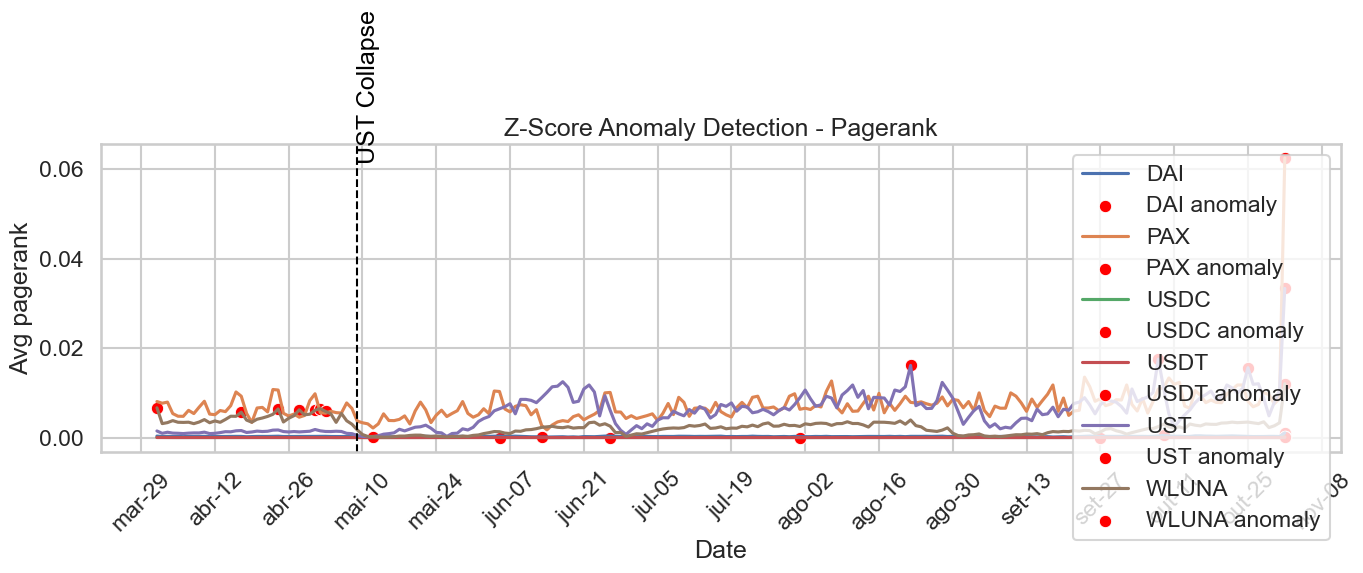

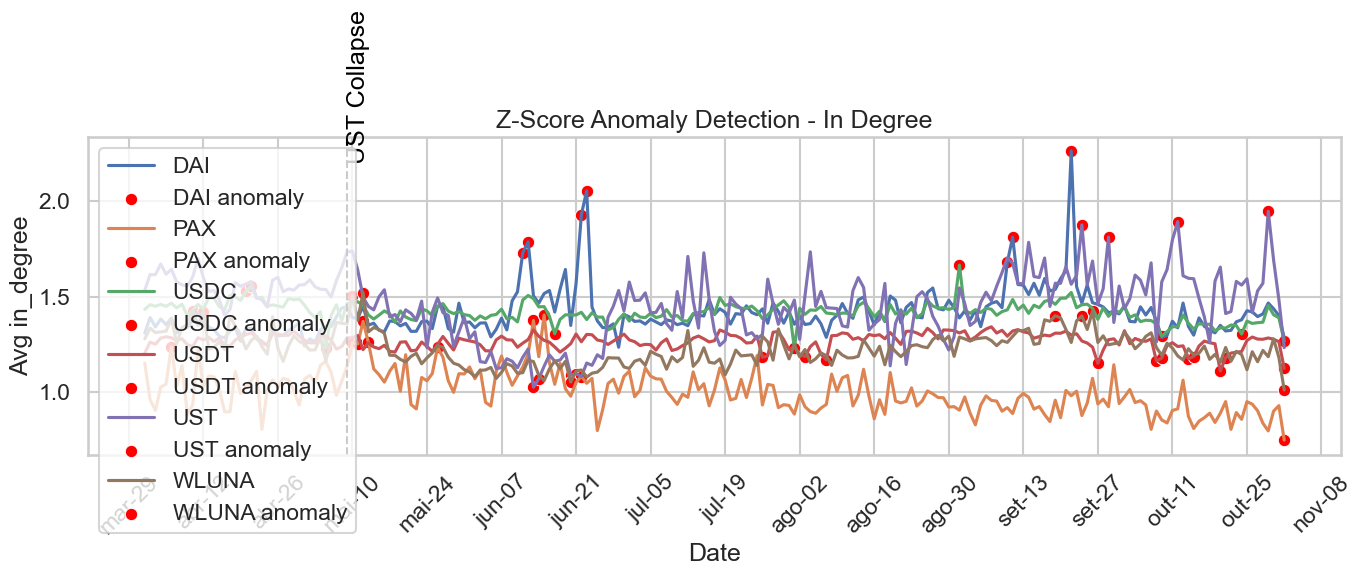

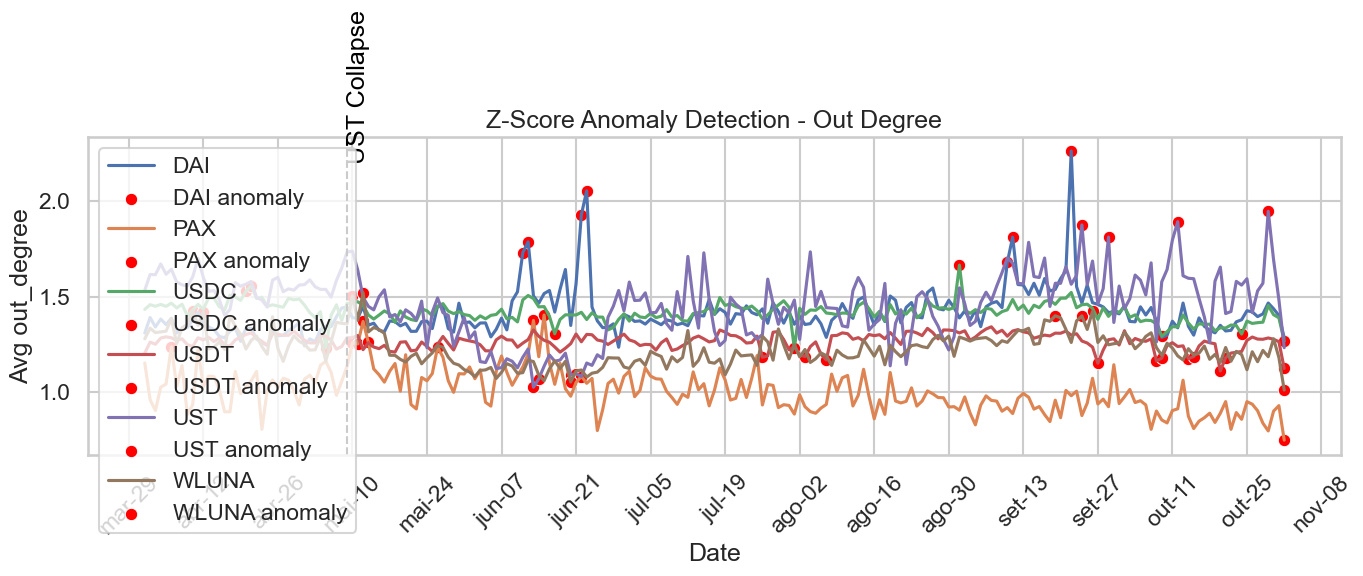

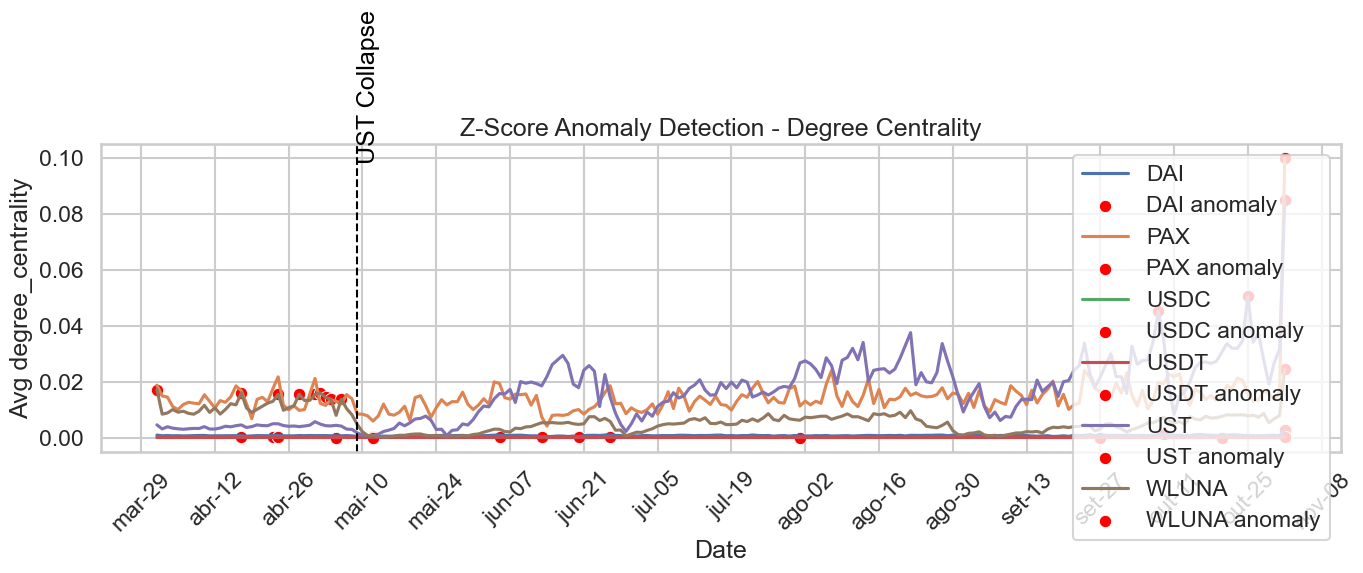

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore

# Estilo visual
sns.set_theme(style="whitegrid", context="talk")

# Carregar e preparar
df = pd.read_parquet('../data/graphs/metrics/all_metrics.parquet')
df['date'] = pd.to_datetime(df['date'])
ust_crash = pd.to_datetime("2022-05-09")

# Métricas e tokens
metrics = ['pagerank', 'in_degree', 'out_degree', 'degree_centrality']
tokens = df['token'].unique()

for metric in metrics:
    plt.figure(figsize=(14, 6))

    for token in tokens:
        subset = df[df['token'] == token].groupby('date')[metric].mean().reset_index()
        subset['zscore'] = zscore(subset[metric])
        subset['anomaly'] = subset['zscore'].abs() > 2  # |z| > 2

        # Linha base
        sns.lineplot(data=subset, x='date', y=metric, label=token)

        # Pontos de anomalia
        sns.scatterplot(
            data=subset[subset['anomaly']],
            x='date', y=metric, label=f'{token} anomaly', marker='o', s=80, color='red'
        )

    # Linha do evento UST
    plt.axvline(ust_crash, color='black', linestyle='--', linewidth=1.5)
    plt.text(ust_crash, plt.ylim()[1]*0.95, 'UST Collapse', rotation=90, color='black')

    # Eixo X
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.xticks(rotation=45)

    plt.title(f'Z-Score Anomaly Detection - {metric.replace("_", " ").title()}')
    plt.xlabel('Date')
    plt.ylabel(f'Avg {metric}')
    plt.tight_layout()
    plt.legend()
    plt.show()
